In [1]:
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import Imagenette
from torchvision.transforms import v2
from torchvision.models import (
    resnet18,
    ResNet18_Weights,
    squeezenet1_1,
    SqueezeNet1_1_Weights,
    vit_b_16,
    ViT_B_16_Weights,
)
import pytorch_lightning as pl
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

pl.seed_everything(42, workers=True)

BATCH = 128
EPOCHS = 2
LR = 1e-3
DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"

In [2]:
transformations = {
    "train": v2.Compose(
        [
            v2.RandomResizedCrop(size=224, interpolation=v2.InterpolationMode.BICUBIC),
            v2.ToImage(),
            v2.ToDtype(torch.float32, scale=True),
            v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
    "val": v2.Compose(
        [
            v2.Resize(size=[224, 224], interpolation=v2.InterpolationMode.BICUBIC),
            v2.ToImage(),
            v2.ToDtype(torch.float32, scale=True),
            v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
}


def get_dataloader(dataset: Dataset, train: bool = False) -> DataLoader:
    return DataLoader(
        dataset,
        batch_size=BATCH,
        drop_last=True,
        shuffle=train,
        num_workers=4,
        pin_memory=torch.cuda.is_available(),  # only if you have enough VRAM
    )


train_dataset = Imagenette(
    root="./data",
    # download=False,
    download=True,
    transform=transformations["train"],
    split="train",
    size="320px",
)

val_dataset = Imagenette(
    root="./data",
    download=False,
    # download=True,
    transform=transformations["val"],
    split="val",
    size="320px",
)

100%|██████████| 341663724/341663724 [00:09<00:00, 34415121.37it/s]


Extracting ./data/train/imagenette2-320.tgz to ./data/train/


100%|██████████| 341663724/341663724 [00:09<00:00, 36286460.68it/s]


Extracting ./data/val/imagenette2-320.tgz to ./data/val/


In [3]:
def freeze_model(model: nn.Module) -> nn.Module:
    for param in model.parameters():
        param.requires_grad = False

    return model


def get_model(name: str) -> nn.Module:
    match name:
        case "resnet":
            model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
            model = freeze_model(model)
            num_ftrs = model.fc.in_features
            model.fc = nn.Linear(num_ftrs, 10)
            for param in model.fc.parameters():
                param.requires_grad = True

        case "squeezenet":
            model = squeezenet1_1(weights=SqueezeNet1_1_Weights.IMAGENET1K_V1)
            model = freeze_model(model)
            model.classifier[1] = nn.Conv2d(512, 10, kernel_size=(1, 1), stride=(1, 1))
            for param in model.classifier[1].parameters():
                param.requires_grad = True
            model.num_classes = 10

        case "vit":
            model = vit_b_16(weights=ViT_B_16_Weights.IMAGENET1K_V1)
            model = freeze_model(model)
            model.heads.head = nn.Linear(768, 10)
            for param in model.heads.head.parameters():
                param.requires_grad = True

    return model

  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

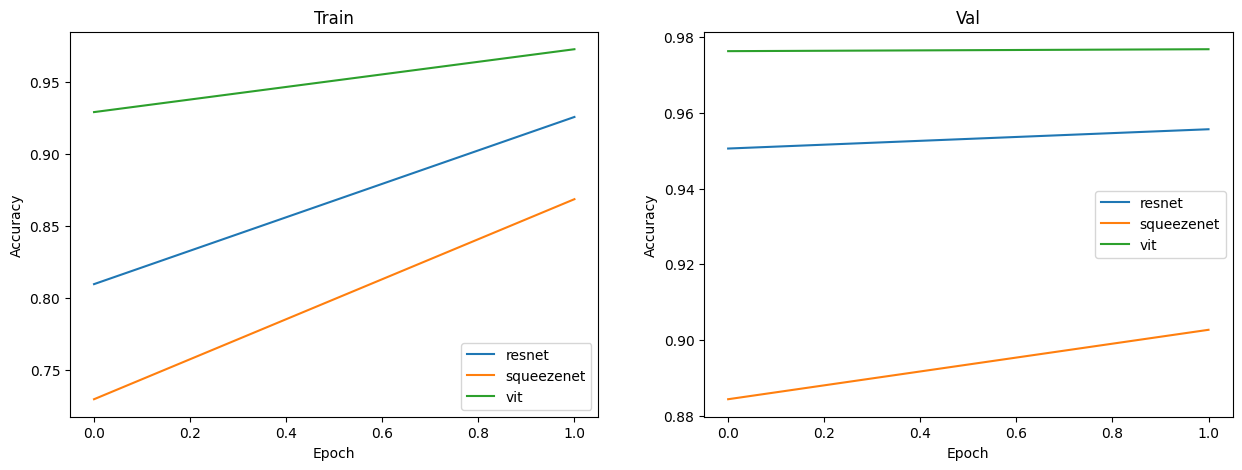

In [12]:
models = ["resnet", "squeezenet", "vit"]
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
for model_name in models:
    model = get_model(model_name).to(DEVICE)
    optimizer = optim.AdamW(model.parameters(), lr=LR)
    criterion = nn.CrossEntropyLoss()
    train_dataloader = get_dataloader(train_dataset, True)
    tr_block = train_dataloader.pin_memory
    val_dataloader = get_dataloader(val_dataset, False)
    val_block = val_dataloader.pin_memory
    train_accuracy, val_accuracy = [0] * EPOCHS, [0] * EPOCHS

    for epoch in range(EPOCHS):
        model.train()
        accuracy = 0

        for features, labels in tqdm(train_dataloader):
            features = features.to(DEVICE, non_blocking=tr_block)
            labels = labels.to(DEVICE, non_blocking=tr_block)
            logits = model(features)
            loss = criterion(logits, labels)
            accuracy += torch.eq(logits.argmax(dim=-1), labels).detach().cpu().sum()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_accuracy[epoch] = (accuracy / len(train_dataset)).item()

        model.eval()
        accuracy = 0

        for features, labels in tqdm(val_dataloader):
            with torch.inference_mode():
                features = features.to(DEVICE, non_blocking=val_block)
                labels = labels.to(DEVICE, non_blocking=val_block)
                logits = model(features)
                loss = criterion(logits, labels)
                accuracy += torch.eq(logits.argmax(dim=-1), labels).cpu().sum()
        val_accuracy[epoch] = (accuracy / len(val_dataset)).item()

    ax[0].plot(train_accuracy, label=model_name)
    ax[1].plot(val_accuracy, label=model_name)

ax[0].set_title("Train")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Accuracy")
ax[0].legend()

ax[1].set_title("Val")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].legend()
plt.show()